In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.ion()   
 
import numpy as np, pandas as pd
import csv
import os
from PIL import Image
import io
import datetime
import time
import os
import copy
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
%matplotlib inline
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Dataset

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')


In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:

paths = os.getcwd()
Train = os.path.join(paths, 'Train')
Test = os.path.join(paths, 'Test')
labels = sorted(train.label.unique().tolist())
list_path = [Train, Test]

#if not os.path.isdir(path)
for folder in list_path:  
    if not os.path.lexists(folder):
        os.mkdir(folder)
        print('{} directory has been created'.format(folder))

for num in labels:
    label_dir = os.path.join(Train, str(num))
    if not os.path.lexists(label_dir):
      os.mkdir(label_dir)
      print(label_dir, 'has been created')
      
sorted(os.listdir(Train))


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [28]:

train_data= []

for ind, data in train.iterrows():
  label, data = data[0], data[1:]
  data = data.values.reshape(28, 28).astype(np.uint8())
  image = Image.fromarray(data)
  train_data.append((image, label))

  folder = os.path.join(Train, str(label))
  filename = f'{ind}.jpeg'
  filepath = os.path.join(folder, filename)
  if not os.path.isfile(filepath):
    image.save(filepath)
    print('Done with {}.jpeg'.format(ind))


In [29]:

test_data= []

for ind, data in test.iterrows():
  data = data.values.reshape(28, 28).astype(np.uint8())
  image = Image.fromarray(data)
  test_data.append(image)
  

  folder = os.path.join(Test)
  filename = f'{ind}.jpeg'
  filepath = os.path.join(folder, filename)
  if not os.path.isfile(filepath):
    image.save(filepath)
    print('Done with {}.jpeg'.format(ind))

In [9]:
test_data[2000]

In [12]:
data_trans = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(0.1307,0.3081)])
             
mnist_loader = torchvision.datasets.MNIST('./Mnist_pytorch', train=True, download=False,
                             transform= data_trans)

#train_data, test_data=train_test_split(pyt_dataset, test_size=0.1)
train_norm = [(data_trans(img), _) for img, _ in train_data]

val_n = int(len(train_norm) * 0.2)
train_n = len(train_norm) - val_n

train_d, val_d = random_split(train_norm, [train_n, val_n])

data = {'Train': train_d,
        'Val': val_d,
        'MTrain': mnist_loader,
        'Test': [data_trans(img) for img in test_data]}

data_loader = {x: torch.utils.data.DataLoader(data[x], batch_size=32, 
                                              shuffle=True) for x in ['Train', 'Val', 'MTrain','Test']}
#data_loader_train = torch.utils.data.DataLoader(train_d, batch_size=32,shuffle=True)

dataset_size = {x: len(data[x]) for x in ['Train','Val', 'MTrain','Test']}

dataset_class = list(range(0, 10))



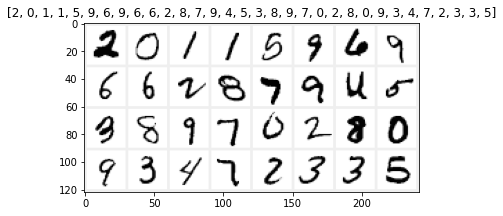

In [13]:
def imshow(data,title = None, one_channel = True):
    if one_channel:
        data = data.mean(dim=0)
    data = data /2 + 0.5 #normalize
    data = data.numpy()
    if one_channel:
        plt.imshow(data, cmap= 'Greys')
    else:
        plt.imshow(np.transpose(data, (1,2,0)))
    if title is not None:
        plt.title(title)
 

inputs, classes = next(iter(data_loader['MTrain']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title = [dataset_class[x] for x in classes])



In [14]:
#borrowed from kaggle notebook

class CNNet(nn.Module):
    def __init__(self):
        super(CNNet, self).__init__()
        self.conv_block = nn.Sequential(nn.Conv2d(1, 32, kernel_size =3, padding = 1, stride =1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(inplace = True),
                                       nn.Conv2d(32, 64, kernel_size =3, padding =1, stride =1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(inplace = True),
                                       nn.MaxPool2d(kernel_size =2, stride =2),
                                       nn.Conv2d(64, 128, kernel_size =3, stride =1, padding =1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(inplace = True),
                                       nn.MaxPool2d(kernel_size =2, stride =2))
        self.lin_block = nn.Sequential(nn.Dropout(0.5),
                                      nn.Linear(128 * 7 *7, 128),
                                      nn.BatchNorm1d(128),
                                      nn.ReLU(inplace = True),
                                      nn.Dropout(0.5),
                                      nn.Linear(128, 64),
                                      nn.BatchNorm1d(64),
                                      nn.ReLU(inplace = True),
                                      nn.Dropout(0.5),
                                      nn.Linear(64, 10))
        
    def forward(self, x):
        out = self.conv_block(x)
        out = out.view(-1, 128*7*7)
        out = self.lin_block(out)
        return out
 
cnn_model = CNNet()

            

In [32]:
def training_loop(model, criterion, optimizer,filename, num_epochs = 5):
    since = time.time()
    start_iter = 1
    best_acc = 0.0
    epoch_vlosses = []
    epoch_vaccs = []

    if filename is not None:
        checkpoint = torch.load(filename)
        ms = checkpoint['model_state']
        start_iter = checkpoint['iteration']
        opts = checkpoint['model_opt']
        model.load_state_dict(ms)
        optimizer.load_state_dict(opts)

    for epoch in range(start_iter, num_epochs +start_iter+1):
        print('Epoch {}/{}'.format(epoch, num_epochs+ start_iter))
        
        for phase in ['MTrain','MTrain' ,'Val']:
          if 'Train' in phase:
            model.train()
          else:
            model.eval()

          running_loss = 0.0
          running_correct = 0
          running_loss_train = 0.0
          running_correct_train = 0


          for inputs, labels in data_loader[phase]:
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase != 'Val'):
                out = model(inputs)
                _, predicted = torch.max(out, 1)
                loss = criterion(out, labels) #.to(device)

                if 'Train' in phase:
                    loss.backward()
                    optimizer.step()
                    running_loss_train += loss.item() * inputs.size(0)
                    running_correct_train += torch.sum(predicted == labels.data)
                    epoch_loss_t = running_loss_train / dataset_size[phase]
                    epoch_acc_t = running_correct_train / dataset_size[phase]
        
                if phase == 'Val':
                    running_loss += loss.item() * inputs.size(0)
                    running_correct += torch.sum(predicted == labels.data)
                    epoch_loss = running_loss / dataset_size[phase]
                    epoch_acc = running_correct / dataset_size[phase]
            
            if phase == 'Val' and epoch_acc > best_acc:
                best_acc = epoch_acc

        if epoch % 5 == 0:
            torch.save({
                'model_state': model.state_dict(), 
                'loss': epoch_loss,
                'acc': epoch_acc,
                'best acc':best_acc,
                'iteration': epoch,
                'model_opt': optimizer.state_dict()}, 'checkpoint.tar')
                    
        print('Train Loss: {:.4f} Train Accuracy: {:.4f}'.format(epoch_loss_t, epoch_acc_t))
        print('Val Loss: {:.4f} Val Accuracy: {:.4f}'.format(epoch_loss, epoch_acc))
     
        epoch_vlosses.append(epoch_loss) 
        epoch_vaccs.append(epoch_acc) #ea.cpu().detach().numpy())
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m/{:.0f}s'.format(time_elapsed //60 , time_elapsed % 60))
        print('')
        print('-'*10)
    print('Best accuracy: {:.4f} Loss {:.4f}'. format(best_acc, epoch_loss))
    #model.load_state_dict(best_model_wts)
    
    return model


In [16]:
def showPlot(plot_losses, title):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base =0.2)
    ax.yaxis.set_major_locator(loc)
    if title is not None:
        plt.title(title)
    plt.plot(plot_losses)

In [17]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loader['Val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(dataset_class[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return model.train(mode=was_training)

In [18]:
cnn_model = cnn_model.to(device)
optimizer = optim.SGD(cnn_model.parameters(), lr= 0.003, momentum= 0.9)
criterion = nn.CrossEntropyLoss()
#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma= 0.1)


In [34]:
cnn_model = training_loop(cnn_model, criterion, optimizer,
              'checkpoint.tar', num_epochs = 5).to(device)
    

Epoch 1640/1645
Train Loss: 0.0773 Train Accuracy: 0.9795
Val Loss: 0.0242 Val Accuracy: 0.9935
Training completed in 0m/40s

----------
Epoch 1641/1645
Train Loss: 0.0794 Train Accuracy: 0.9790
Val Loss: 0.0238 Val Accuracy: 0.9933
Training completed in 1m/19s

----------
Epoch 1642/1645
Train Loss: 0.0766 Train Accuracy: 0.9800
Val Loss: 0.0240 Val Accuracy: 0.9938
Training completed in 1m/58s

----------
Epoch 1643/1645
Train Loss: 0.0758 Train Accuracy: 0.9797
Val Loss: 0.0248 Val Accuracy: 0.9936
Training completed in 2m/38s

----------
Epoch 1644/1645
Train Loss: 0.0809 Train Accuracy: 0.9791
Val Loss: 0.0258 Val Accuracy: 0.9931
Training completed in 3m/16s

----------
Epoch 1645/1645
Train Loss: 0.0808 Train Accuracy: 0.9790
Val Loss: 0.0235 Val Accuracy: 0.9939
Training completed in 3m/56s

----------
Best accuracy: 0.9939 Loss 0.0235


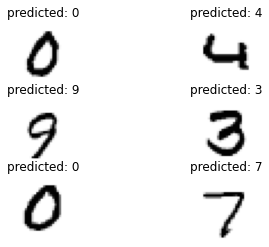

In [27]:
visualize_model(cnn_model)

plt.ioff()
plt.show()